In [231]:
# === Imports ===
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skew, kurtosis, zscore
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
)
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
)

from sklearn.metrics import roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [232]:
data_selected  = pd.read_csv("water_quality_cleaned.csv")
data_selected .head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,6.889209,115.354726,14956.795132,8.419947,348.147309,445.534077,20.023058,52.035790,4.600602,1
1,7.299055,236.398669,38337.306822,8.475545,328.778773,450.165393,19.904529,96.228498,4.690844,0
2,6.015049,201.467619,9048.799422,11.078408,328.424198,433.477138,14.552373,64.938492,2.863421,1
3,6.703759,134.417470,7263.603388,10.029884,328.778773,745.729830,13.735217,33.467998,1.450000,1
4,7.226719,117.286940,16144.528706,9.107206,345.916915,642.628467,4.402219,86.147319,5.401486,0


In [233]:
data_selected.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

In [234]:
print(data_selected.info())
print("\nShape:", data_selected.shape)
print("\nColumns:", list(data_selected.columns))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               70000 non-null  float64
 1   Hardness         70000 non-null  float64
 2   Solids           70000 non-null  float64
 3   Chloramines      70000 non-null  float64
 4   Sulfate          70000 non-null  float64
 5   Conductivity     70000 non-null  float64
 6   Organic_carbon   70000 non-null  float64
 7   Trihalomethanes  70000 non-null  float64
 8   Turbidity        70000 non-null  float64
 9   Potability       70000 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 5.3 MB
None

Shape: (70000, 10)

Columns: ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability']


In [235]:
print(data_selected.isnull().sum())

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


In [236]:
print("Number of duplicates:", data_selected.duplicated().sum())

Number of duplicates: 0


In [237]:
print(data_selected.describe().T)

                   count          mean           std         min          25%  \
ph               70000.0      7.501371      1.436709    3.362436     6.974489   
Hardness         70000.0    179.283943     50.399548   47.432000   154.231766   
Solids           70000.0  20187.849375  14393.206013  320.942611  9093.301122   
Chloramines      70000.0      8.762674      2.190657    0.352000     7.472131   
Sulfate          70000.0    321.521567     43.515991  129.000000   308.198258   
Conductivity     70000.0    479.708116    119.830543  181.483754   391.821897   
Organic_carbon   70000.0     14.560028      4.917560    2.200000    11.085317   
Trihalomethanes  70000.0     74.598621     23.108499    6.890942    60.654826   
Turbidity        70000.0      3.783859      1.231779    1.450000     2.912414   
Potability       70000.0      0.483829      0.499742    0.000000     0.000000   

                          50%           75%           max  
ph                   7.299055      7.979408     

In [238]:
for col in data_selected.select_dtypes(include=np.number).columns:
    print(f"{col:20}  Skewness = {skew(data[col]):.2f}  |  Kurtosis = {kurtosis(data[col]):.2f}")

ph                    Skewness = 0.60  |  Kurtosis = 2.09
Hardness              Skewness = -0.59  |  Kurtosis = 0.21
Solids                Skewness = 0.84  |  Kurtosis = 0.36
Chloramines           Skewness = -0.51  |  Kurtosis = 0.28
Sulfate               Skewness = -0.79  |  Kurtosis = 3.51
Conductivity          Skewness = 0.09  |  Kurtosis = -0.48
Organic_carbon        Skewness = -0.19  |  Kurtosis = -0.39
Trihalomethanes       Skewness = -0.27  |  Kurtosis = 0.40
Turbidity             Skewness = -0.02  |  Kurtosis = -0.62
Potability            Skewness = 0.06  |  Kurtosis = -2.00


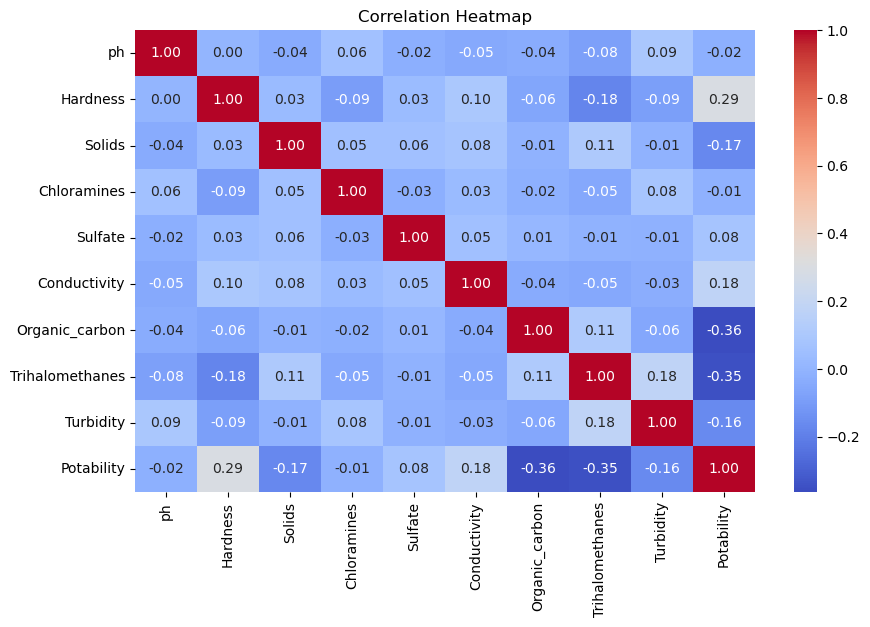

In [239]:
plt.figure(figsize=(10, 6))
sns.heatmap(data_selected.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Potability
0    51.617143
1    48.382857
Name: proportion, dtype: float64


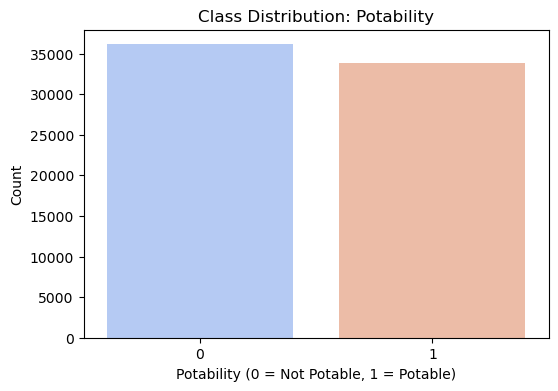

In [240]:
print(data_selected[target_col].value_counts(normalize=True) * 100)
plt.figure(figsize=(6,4))
sns.countplot(x=target_col, data=data_selected, hue=target_col, palette="coolwarm", legend=False)
plt.title("Class Distribution: Potability")
plt.xlabel("Potability (0 = Not Potable, 1 = Potable)")
plt.ylabel("Count")
plt.show()

In [241]:
important_features = [
    'Chloramines',
    'Sulfate',
    'ph',
    'Trihalomethanes',
    'Organic_carbon',
    'Hardness'
]


In [242]:
X = data_selected[important_features]
y = data_selected['Potability']

In [243]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nTrain Shape: {X_train.shape}")
print(f"Test Shape:  {X_test.shape}")


Train Shape: (56000, 6)
Test Shape:  (14000, 6)


In [244]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('power', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, X_train.columns)
])

In [245]:
xgb_model = XGBClassifier(
    n_estimators=300,          # more trees for better learning
    learning_rate=0.012,       # low LR for stability
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.2,
    reg_alpha=0.3,
    min_child_weight=2,
    gamma=0.05,
    random_state=42,
    eval_metric="auc",
    n_jobs=-1
)

In [246]:
# === Full Pipeline with SMOTE ===
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy=1.0, random_state=42)),  # balance classes
    ('model', xgb_model)
])

In [247]:
# === Train Pipeline ===
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('power',
                                                                   PowerTransformer())]),
                                                  Index(['Chloramines', 'Sulfate', 'ph', 'Trihalomethanes', 'Organic_carbon',
       'Hardness'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42, sampling_strategy=1.0)),
                ('model',
                 XGBClassifier(base_score=None, booster...
                               feature_types=None, feature_weights=None,
                               gamma=0.05, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.012, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=2, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [248]:
y_train_pred = pipeline.predict(X_train)
y_train_prob = pipeline.predict_proba(X_train)[:, 1]

y_test_pred = pipeline.predict(X_test)
y_test_prob = pipeline.predict_proba(X_test)[:, 1]

roc_train = roc_auc_score(y_train, y_train_prob)
roc_test = roc_auc_score(y_test, y_test_prob)

print(f"ROC–AUC Train: {roc_train:.4f}")
print(f"ROC–AUC Test:  {roc_test:.4f}")

print("\n--- TRAIN Classification Report ---\n", classification_report(y_train, y_train_pred))
print("\n--- TEST Classification Report ---\n", classification_report(y_test, y_test_pred))

ROC–AUC Train: 0.9218
ROC–AUC Test:  0.9133

--- TRAIN Classification Report ---
               precision    recall  f1-score   support

           0       0.85      0.83      0.84     28906
           1       0.82      0.84      0.83     27094

    accuracy                           0.83     56000
   macro avg       0.83      0.83      0.83     56000
weighted avg       0.83      0.83      0.83     56000


--- TEST Classification Report ---
               precision    recall  f1-score   support

           0       0.84      0.82      0.83      7226
           1       0.81      0.84      0.82      6774

    accuracy                           0.83     14000
   macro avg       0.83      0.83      0.83     14000
weighted avg       0.83      0.83      0.83     14000



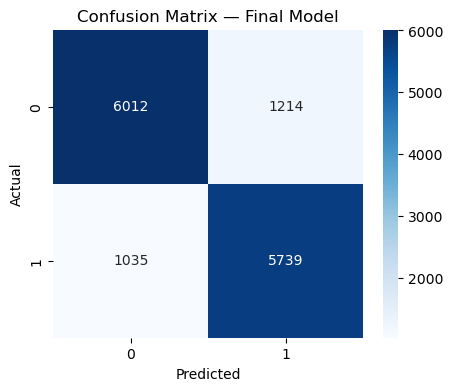

In [249]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix — Final Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [250]:
import joblib

# Save pipeline with compression
joblib.dump(pipeline, 'water_quality.pkl', compress=3)
print("Pipeline saved with compression successfully!")


Pipeline saved with compression successfully!
